In [34]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import uproot
import awkward as ak
import tabulate as tab
import glob
import h5py

In [5]:
def get_info(akw, display=False):
    # akw['waveformsADC'][trigRec][chID]
    Nevents    = len(akw['waveformsADC'])
    TrigWindow = len(akw['waveformsADC'][0][0])
    Nchannels  = len(akw['waveformsADC'][0])
    maxima = []
    for chID in range(0, Nchannels):
        maxima.append(ak.max( akw['waveformsADC'][:][chID]) )
    if display:
        print(' events', Nevents)
        print(' trigger window', TrigWindow)
        print(' number of channels', Nchannels)
        print(' max height', int(np.max(maxima)) )
    return Nevents, TrigWindow, Nchannels, maxima

In [6]:
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data'
filepath = f'{cernbox}/anaCRP_files'

In [ ]:
files = glob.glob(f"{filepath}/pns_nTuples_r25036_*.pkl")
# pns = {}
# for file in files[:2]:
#     print(file)
#     with open(file, "rb") as f:
#         pns.update(pickle.load(f))

_, _, _, _ = get_info(pns, display=True)

/Users/emiliebertholet/cernbox/coldbox_data/anaCRP_files/pns_nTuples_r25036_8-16.pkl
/Users/emiliebertholet/cernbox/coldbox_data/anaCRP_files/pns_nTuples_r25036_0-7.pkl
 events 2324
 trigger window 65600
 number of channels 12
 max height 16383


In [28]:
pns = None

for file in files:
    with open(file, "rb") as f:
        data = pickle.load(f)

    if pns is None:
        # First file: initialize the dictionary
        pns = {k: v.copy() for k, v in data.items()}
    else:
        # Concatenate arrays for each key
        for k in pns:
            pns[k] = np.concatenate((pns[k], data[k]), axis=0)

_, _, _, _ = get_info(pns, display=True)

 events 9960
 trigger window 65600
 number of channels 12
 max height 16383


In [45]:
files = sorted( glob.glob(os.path.join(filepath, "pns_nTuples_r25036_*.h5")) )
waveforms_list = []
pedestal_list = []

for file in files:
    print(file)
    with h5py.File(file, "r") as f:
        waveforms_list.append(f["waveformsADC"][:])  
        pedestal_list.append(f["pedestals"][:])

pns = {
    "waveformsADC": np.vstack(waveforms_list), 
    "pedestals": np.concatenate(pedestal_list)  
}

/Users/emiliebertholet/cernbox/coldbox_data/anaCRP_files/pns_nTuples_r25036_0-7.h5
/Users/emiliebertholet/cernbox/coldbox_data/anaCRP_files/pns_nTuples_r25036_17-30.h5
/Users/emiliebertholet/cernbox/coldbox_data/anaCRP_files/pns_nTuples_r25036_8-16.h5


In [46]:
_, _, _, _ = get_info(pns, display=True)

 events 9960
 trigger window 65600
 number of channels 12
 max height 16383


In [47]:
with h5py.File("pns_nTuples_r25036_0-30.h5", "w") as h5:
    for key, arr in pns.items():
        h5.create_dataset(key, data=arr)

In [48]:
with h5py.File("pns_nTuples_r25036_0-30.h5", "r") as f:
    pns = {key: f[key][:] for key in f.keys()}

In [49]:
_, _, _, _ = get_info(pns, display=True)

 events 9960
 trigger window 65600
 number of channels 12
 max height 16383


In [ ]:
d1 = {
    'waveformsADC': np.array( [[1,2,3], 
                               [4,5,6]] ),
    'pedestals':     np.array( [1, 2])
}
d2 = {
    'waveformsADC': np.array( [[10,20,30], 
                               [40,50,60]] ),
    'pedestals':     np.array( [100, 100])
}

waveforms_list = []
pedestal_list = []
for d in [d1, d2]:
    waveforms_list.append(d['waveformsADC'][:])
    pedestal_list.append(d['pedestals'][:])
res = {
    "waveformsADC": np.vstack(waveforms_list),  # stack rows
    "pedestal": np.concatenate(pedestal_list)   # flat concat
}
res

{'waveformsADC': array([[ 1,  2,  3],
        [ 4,  5,  6],
        [10, 20, 30],
        [40, 50, 60]]),
 'pedestal': array([  1,   2, 100, 100])}

In [38]:
2324+2988+4648

9960

In [ ]:
# pns_nTuples_r25036_0-7.pkl
#  events 2324
#  trigger window 65600
#  number of channels 12
#  max height 16383

# pns_nTuples_r25036_8-16.pkl
#  events 2988
#  trigger window 65600
#  number of channels 12
#  max height 16383

# pns_nTuples_r25036_17-30.pkl
# events 4648
#  trigger window 65600
#  number of channels 12
#  max height 16383






SyntaxError: invalid syntax (2806687520.py, line 1)

In [8]:
files = glob.glob(f"{filepath}/cos_nTuples_r25004_*.pkl")
cos = {}
for file in files:
    with open(file, "rb") as f:
        cos.update(pickle.load(f))

In [9]:
print('PNS')
_, _, _, _ = get_info(pns, display=True)
print('Cosmics')
_, _, _, _ = get_info(cos, display=True)

PNS
 events 4648
 trigger window 65600
 number of channels 12
 max height 16383
Cosmics
 events 756
 trigger window 262208
 number of channels 12
 max height 16383


## 

# Pedestal Subtraction

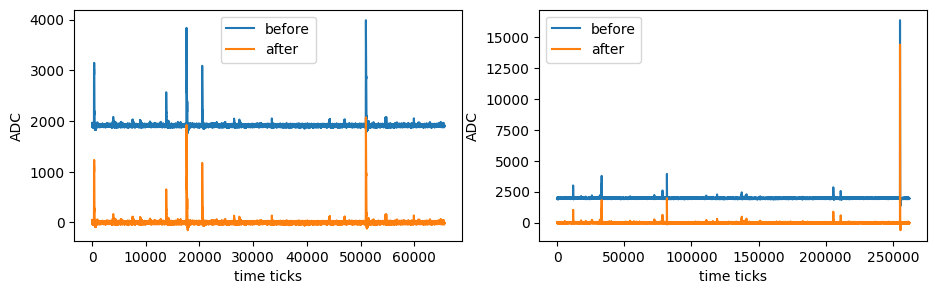

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))
idx, chID = 342, 2
axs[0].plot(pns['waveformsADC'][idx, chID], label='before')
axs[0].plot(pns['waveformsADC'][idx, chID] - pns['pedestals'][idx, chID], label='after')
axs[0].set_xlabel('time ticks')
axs[0].set_ylabel('ADC')
axs[0].legend(loc='upper center')
axs[1].plot(cos['waveformsADC'][idx, chID], label='before')
axs[1].plot(cos['waveformsADC'][idx, chID] - cos['pedestals'][idx, chID], label='after')
axs[1].set_xlabel('time ticks')
axs[1].set_ylabel('ADC')
axs[1].legend()

## Flag events with unstable baseline

In [7]:
def estimate_baseline_stability(waveform, max_deviation=5):
    median = np.median(waveform)
    mad = np.median(np.abs(waveform - median))

    quiet = np.abs(waveform - median) < max_deviation * mad

    if not np.any(quiet):  # if mask is empty
        return np.nan, np.nan, quiet ### maybe should return an arbitrary high number instead (e.g. 99999)

    baseline = np.mean(waveform[quiet])
    rms = np.std(waveform[quiet])
    return baseline, rms, quiet

def add_baseline_stability_estimate(sample):
    wfs = sample['waveformsADC']
    Nevents, _, Nchannels, _ = get_info(sample, display=False)
    sample['baseline_stability'] = np.array([[estimate_baseline_stability(wfs[trigID, chID], max_deviation=5)[1] for chID in range(Nchannels)] for trigID in range(Nevents)])



In [8]:
add_baseline_stability_estimate(pns)
add_baseline_stability_estimate(cos)

In [9]:
cut = 40
lines = [['channel', 'PNS rejection [%]', 'Cosmics rejection [%]']]
rej_pns, rej_cos = [], []
Nevents_pns, _, Nchannels, _ = get_info(pns, display=False)
Nevents_cos, _, Nchannels, _ = get_info(cos, display=False)
for chID in range(Nchannels):
    sel_pns = pns['baseline_stability'][pns['baseline_stability'][:, chID]>40][:,chID]
    rej_pns.append(sel_pns.shape[0]*100/Nevents_pns)
    sel_cos = cos['baseline_stability'][cos['baseline_stability'][:, chID]>40][:,chID]
    rej_cos.append(sel_cos.shape[0]*100/Nevents_cos)
    lines.append( [chID, f'{rej_pns[chID]:.1f}', f'{rej_cos[chID]:.1f}'] )
print(tab.tabulate(lines, headers="firstrow", tablefmt="github"))

|   channel |   PNS rejection [%] |   Cosmics rejection [%] |
|-----------|---------------------|-------------------------|
|         0 |                11.3 |                     3.7 |
|         1 |                 3   |                    13.3 |
|         2 |                 8   |                    15.8 |
|         3 |                 7.9 |                     4.9 |
|         4 |                 7.3 |                    50.5 |
|         5 |                 9.3 |                    16   |
|         6 |                87.9 |                    48.8 |
|         7 |                 0   |                     0   |
|         8 |                35.1 |                    37.1 |
|         9 |                 0   |                   100   |
|        10 |               100   |                     0   |
|        11 |                 0   |                     0   |


# Extract Peaks

In [10]:
from scipy.signal import find_peaks

def find_peaks_2d(array_trigRecxTT, **kwargs):
    """
    Find peaks in a 2D waveform array (trigRec x tt).
    
    Args:
        array_2d: np.ndarray shape (N_trigRecs, N_tt)
        kwargs: arguments for `scipy.signal.find_peaks`, e.g. height, distance, width

    Returns:
        dict with:
            - 'peak_indices': list of np.arrays with peak positions
            - 'peak_heights': list of np.arrays with peak heights
            - 'properties': list of full peak properties per waveform
            - 'pulses': list of slices around peaks (if width info available)
    """
    props_list = []
    peak_indices = []
    peak_heights = []
    peak_slices = []

    for row_idx, row in enumerate(array_trigRecxTT):
        peaks, props = find_peaks(row, **kwargs)

        # getters
        heights  = props.get("peak_heights", row[peaks])
        # left_ips = props.get("left_ips", props)

        # Extract waveform slices around peaks (if widths are calculated)
        slices = []
        if "left_ips" in props and "right_ips" in props:
            for l, r in zip(props["left_ips"], props["right_ips"]):
                start = max(0, int(np.floor(l)))
                end   = min(len(row), int(np.ceil(r)))
                slices.append(row[start:end])
        else:
            slices = [np.array([row[p]]) for p in peaks]  # fallback: just peak value

        # Collect
        props_list.append(props)
        peak_indices.append(peaks)
        peak_heights.append(heights)
        peak_slices.append(slices)

    return {
        "peak_indices": peak_indices,
        "peak_heights": peak_heights,
        "properties": props_list,
        "pulses": peak_slices,
    }

def test_plot(result, waveform, chID, trigRec, avg=True, few_pulses=None):
    print('Selection applied to test plot:')
    print('  - remove stauration')
    print('  - subtract pedestal')
    fig, axs = plt.subplots(1, 2, figsize=(11, 3))
    peak_indices = result['peak_indices'][trigRec]
    full_waveform = waveform['waveformsADC'][trigRec, chID]
    ax = axs[0]
    ax.plot(full_waveform, label="Trigger Record")
    ax.plot(peak_indices, full_waveform[peak_indices], "rx", label="Peaks")
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')

    _, _, _, maxima = get_info(waveform, display=False)
    ADCsat = int(np.max(maxima))
    wfs_pns = []
    pedestal = waveform['pedestals'][trigRec, chID] 
    pedestal
    wfs_pns  = [w - pedestal for w in result['pulses'][trigRec]]
    ax = axs[1]
    pulses_noSat = []
    if few_pulses is not None:
        wfs_pns = wfs_pns[few_pulses[0]:few_pulses[1]]
    for pulse in wfs_pns:
        if np.max(pulse)<ADCsat:
            ax.plot( pulse );
        pulses_noSat.append(pulse)
    if avg:
        avg_pns = ak.mean(pulses_noSat, axis=0)
        ax.plot(avg_pns, color='black', label='average')
        ax.legend()
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC - pedestal');
    return wfs_pns

In [34]:
chID = 2

In [35]:
pns_result = find_peaks_2d(pns['waveformsADC'][:, chID],  distance=300, prominence=200, wlen=300, rel_height=0.9, width=0)
cos_result = find_peaks_2d(cos['waveformsADC'][:, chID],  distance=300, prominence=200, wlen=300, rel_height=0.9, width=0)
pns_result.keys()

/var/folders/80/x5l9nnmd2gb3szz23pnjrgpm0000gn/T/ipykernel_57775/580824128.py:24: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(row, **kwargs)


dict_keys(['peak_indices', 'peak_heights', 'properties', 'pulses'])

Selection applied to test plot:
  - remove stauration
  - subtract pedestal


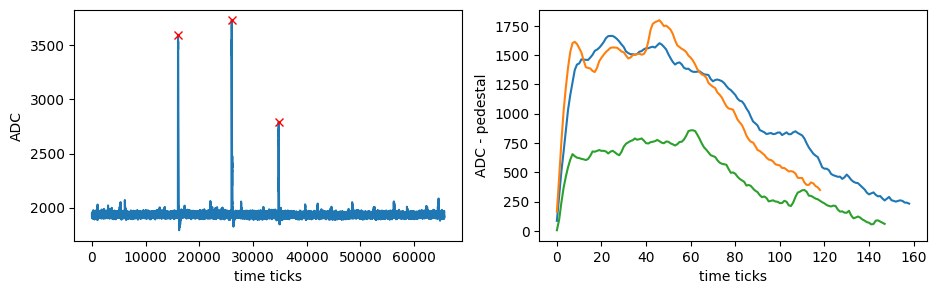

In [36]:
trigRec = 0
selected_pulses = test_plot(pns_result, pns, chID, trigRec, avg=False, few_pulses=None)

Selection applied to test plot:
  - remove stauration
  - subtract pedestal


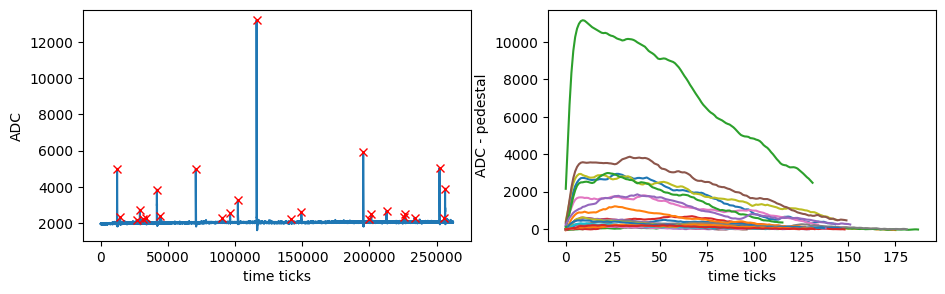

In [37]:
trigRec = 0
selected_pulses = test_plot(cos_result, cos, chID, trigRec, avg=False, few_pulses=None)

## Select peaks

In [38]:
def apply_selection(result, sample, chID, rms_cut, max_peak_position, remove_pedestal=True):
    print('Selection:')
    print(f'  1. remove stauration')
    if remove_pedestal: print(f'  2. subtract pedestal')
    if rms_cut is not None: print(f'  3. use only trigger records with stable baseline (rms_cut = {rms_cut})')
    if max_peak_position is not None: print(f'  4. peak position < {max_peak_position}')

    _, _, _, maxima = get_info(sample, display=False)
    
    # 1. remove saturation
    ADCsat = int(np.max(maxima))
    step1 = [[pulse for pulse in trigRec if np.max(pulse)<ADCsat] for trigRec in result['pulses'] ]
    
    # 2. subtract pedestal
    if remove_pedestal:
        pedestals = sample['pedestals'][:, chID] 
        step2  = [[pulse-pedestals[i] for pulse in step1[i]] for i in range(len(step1))]
    else:
        step2  = step1

    # 3. use only trigger records with stable baseline
    if rms_cut is not None:
        baseline_stability = sample['baseline_stability'][:, chID] 
        step3  = [[pulse for pulse in step2[i] if baseline_stability[i]<rms_cut] for i in range(len(step2))]
    else:
        step3 = step2

    # 4. cut on peak position
    if max_peak_position is not None:
        step4  = [[pulse for pulse in step3[i] if np.argmax(pulse)<max_peak_position] for i in range(len(step3))]
    else:
        step4 = step3

    selection = step4
    
    return selection


Selection:
  1. remove stauration
Selection:
  1. remove stauration
  2. subtract pedestal
Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)


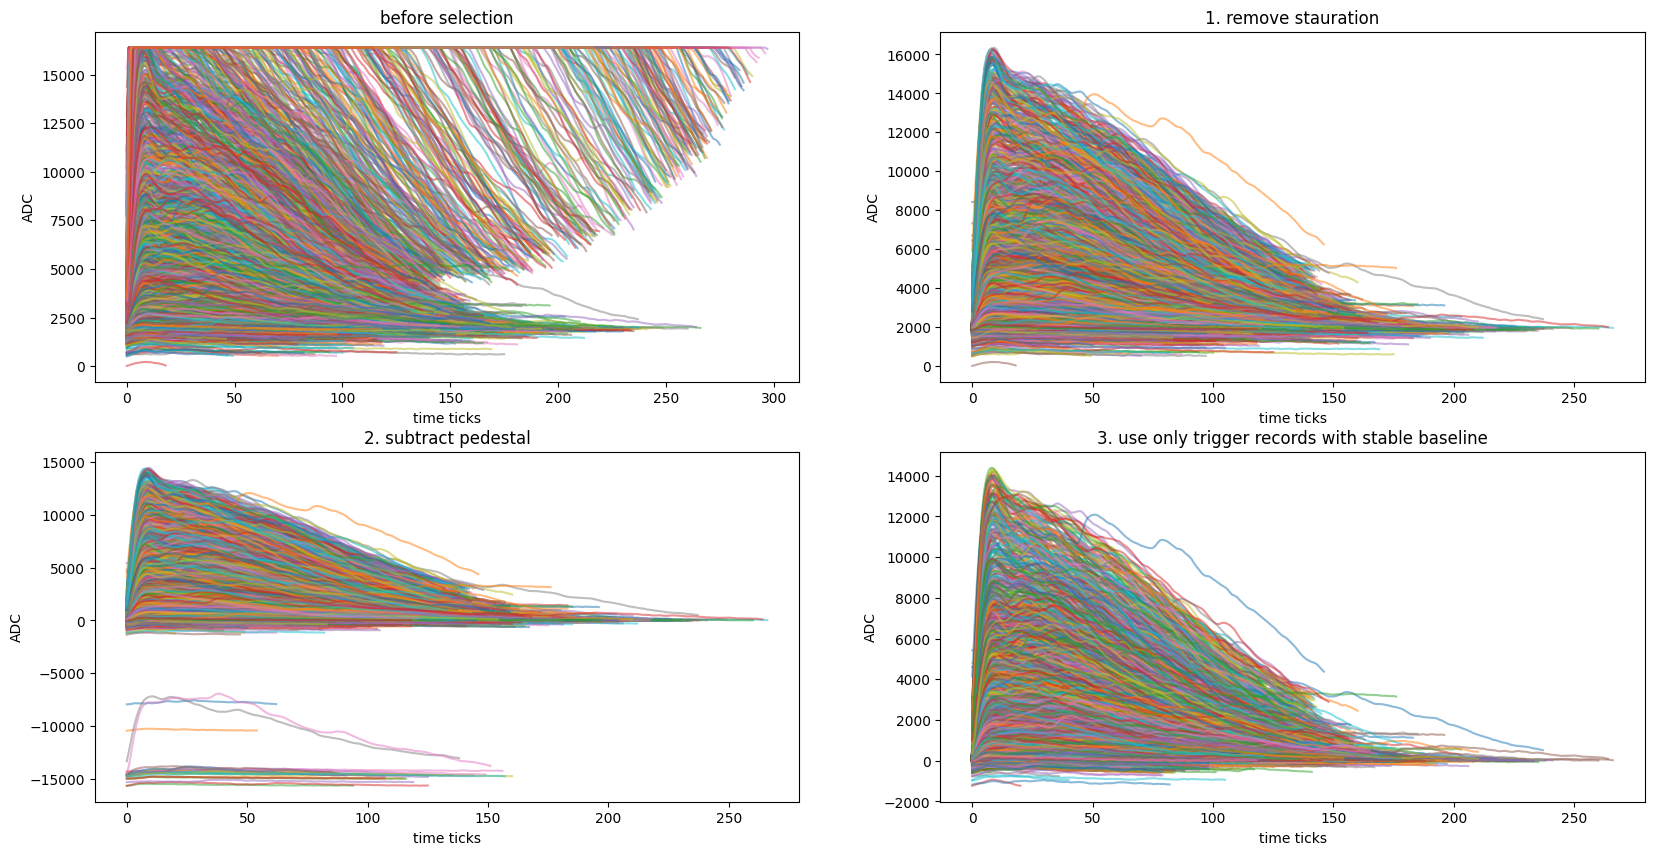

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

ax = axs.flatten()[0]
plot_pulses = [sub for group in pns_result['pulses'] for sub in group]
for wf in plot_pulses:
    ax.plot(wf, alpha=0.5) 
ax.set_title(f"before selection")
ax.set_xlabel("time ticks")
ax.set_ylabel("ADC")

ax = axs.flatten()[1]
selected_pulses = apply_selection(pns_result, pns, chID, rms_cut=None, max_peak_position=None, remove_pedestal=False)
plot_pulses = [sub for group in selected_pulses for sub in group]
for wf in plot_pulses:
    ax.plot(wf, alpha=0.5) 
ax.set_title(f"1. remove stauration")
ax.set_xlabel("time ticks")
ax.set_ylabel("ADC")

ax = axs.flatten()[2]
selected_pulses = apply_selection(pns_result, pns, chID, rms_cut=None, max_peak_position=None, remove_pedestal=True)
plot_pulses = [sub for group in selected_pulses for sub in group]
for wf in plot_pulses:
    ax.plot(wf, alpha=0.5) 
ax.set_title(f"2. subtract pedestal")
ax.set_xlabel("time ticks")
ax.set_ylabel("ADC")

ax = axs.flatten()[3]
selected_pulses = apply_selection(pns_result, pns, chID, rms_cut=40, max_peak_position=None, remove_pedestal=True)
plot_pulses = [sub for group in selected_pulses for sub in group]
for wf in plot_pulses:
    ax.plot(wf, alpha=0.5) 
ax.set_title(f"3. use only trigger records with stable baseline")
ax.set_xlabel("time ticks")
ax.set_ylabel("ADC")

plt.show()


In [40]:
rms_cut = 40
max_peak_position = 30

Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)
  4. peak position < 30
  5. discard pulses shorter than 100 time ticks


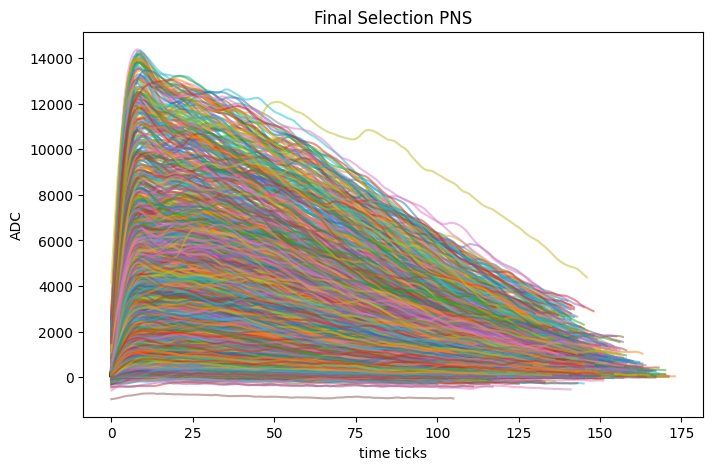

In [41]:
selected_pulses_pns = apply_selection(pns_result, pns, chID, rms_cut=rms_cut, max_peak_position=max_peak_position, remove_pedestal=True)
selected_pulses_pns  = [[pulse for pulse in selected_pulses_pns[i] if len(pulse)>100] for i in range(len(selected_pulses_pns))]
print('  5. discard pulses shorter than 100 time ticks')
plt.figure(figsize=(8, 5))
pulses_flat_pns = [sub for group in selected_pulses_pns for sub in group]
for wf in pulses_flat_pns:
    plt.plot(wf, alpha=0.5) 
plt.title(f"Final Selection PNS")
plt.xlabel("time ticks")
plt.ylabel("ADC")
plt.show()

Selection:
  1. remove stauration
  2. subtract pedestal
  3. use only trigger records with stable baseline (rms_cut = 40)
  4. peak position < 30
  5. discard pulses shorter than 100 time ticks


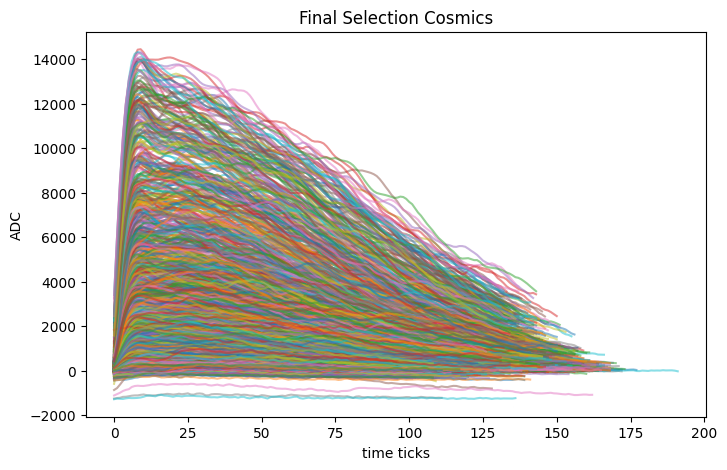

In [42]:
selected_pulses_cos = apply_selection(cos_result, cos, chID, rms_cut=rms_cut, max_peak_position=max_peak_position, remove_pedestal=True)
selected_pulses_cos  = [[pulse for pulse in selected_pulses_cos[i] if len(pulse)>100] for i in range(len(selected_pulses_cos))]
print('  5. discard pulses shorter than 100 time ticks')
plt.figure(figsize=(8, 5))
pulses_flat_cos = [sub for group in selected_pulses_cos for sub in group]
for wf in pulses_flat_cos:
    plt.plot(wf, alpha=0.5) 
plt.title(f"Final Selection Cosmics")
plt.xlabel("time ticks")
plt.ylabel("ADC")
plt.show()

### Get rid of waveforms with large after pulses

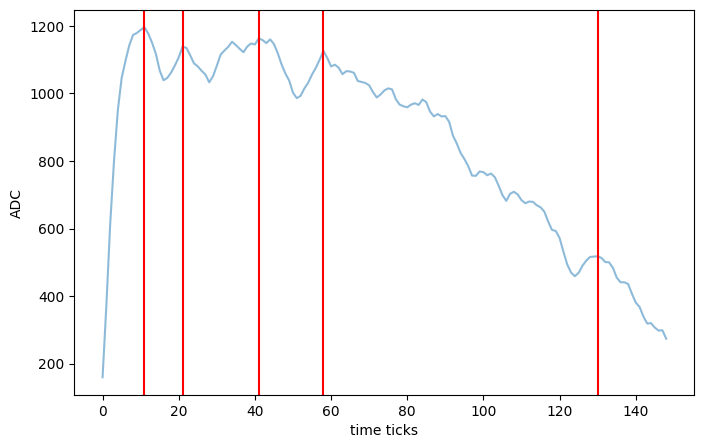

In [43]:
e = 10
test_flat = pulses_flat_pns[e:e+1]

peaks, props = find_peaks(test_flat[0], distance=None, prominence=50, wlen=None)

plt.figure(figsize=(8, 5))
for wf in test_flat:
    plt.plot(wf, alpha=0.5) 
for peak in peaks:
    plt.axvline(x = peak, color='red')
plt.xlabel("time ticks")
plt.ylabel("ADC")
plt.show()

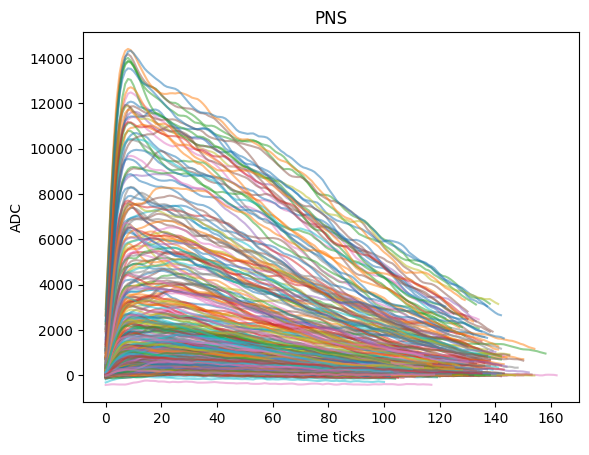

In [44]:
pulses_flat_pns = [sub for group in selected_pulses_pns for sub in group]

single_peak_flat_pns = []
for wf in pulses_flat_pns:
    peaks, props = find_peaks(wf, distance=None, prominence=50, wlen=None)
    if len(peaks)<2:
        plt.plot(wf, alpha=0.5) 
        single_peak_flat_pns.append(wf)
plt.title(f"PNS")
plt.xlabel("time ticks")
plt.ylabel("ADC")
plt.show()

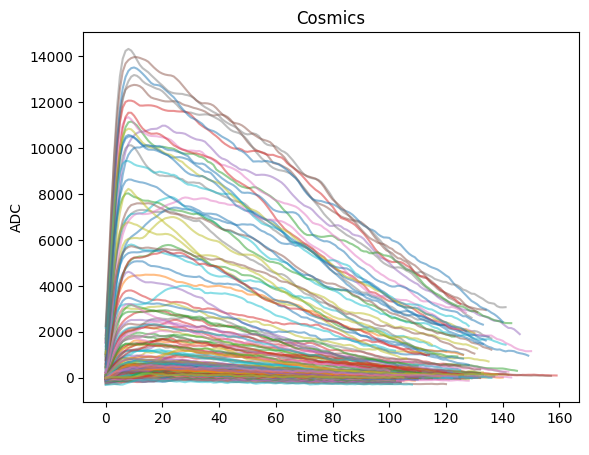

In [45]:

pulses_flat_cos = [sub for group in selected_pulses_cos for sub in group]

single_peak_flat_cos = []
for wf in pulses_flat_cos:
    peaks, props = find_peaks(wf, distance=None, prominence=50, wlen=None)
    if len(peaks)<2:
        plt.plot(wf, alpha=0.5) 
        single_peak_flat_cos.append(wf)
plt.title(f"Cosmics")
plt.xlabel("time ticks")
plt.ylabel("ADC")
plt.show()

# Average

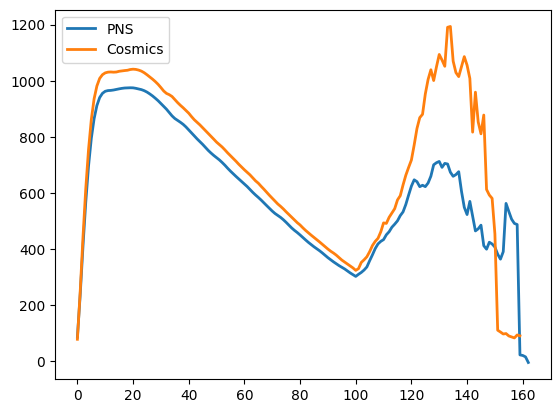

In [46]:
plt.plot(ak.mean(single_peak_flat_pns, axis=0), linewidth=2, label='PNS')
plt.plot(ak.mean(single_peak_flat_cos, axis=0), linewidth=2, label='Cosmics')
plt.legend()
plt.show()

# PSD

In [47]:
def prompt_frac(waveforms, tot_int_boundaries, prompt_int_boundaries):
    promptFrac, Int, ratio = [], [], []
    for p in waveforms:
        peak_position = p.argmax()
        lim_inf = peak_position+prompt_int_boundaries[0]
        lim_sup = peak_position+prompt_int_boundaries[1]
        if lim_inf<0:
            lim_inf = 0
        pf = p[lim_inf:lim_sup].sum()
        integ = p[tot_int_boundaries[0]:tot_int_boundaries[1]].sum()
        r = pf/integ
        promptFrac.append( pf )
        Int.append( integ )
        ratio.append( r )
    return np.array(Int), np.array(ratio)

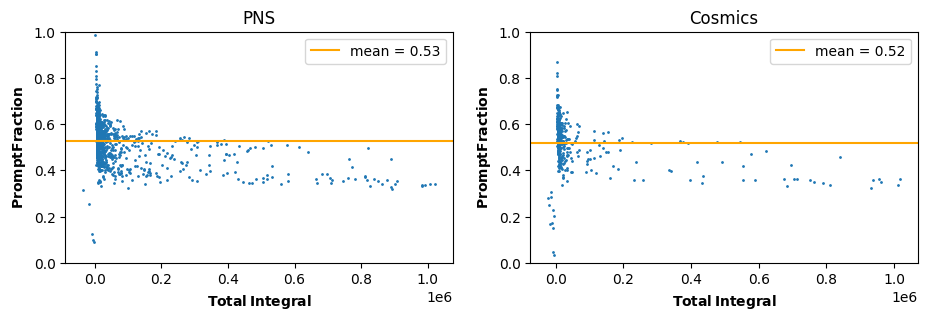

In [48]:
bmin_baseline, bmax_baseline = (0, 100)
prompt_boundaries = (-20,  20)


fig, axs = plt.subplots(1, 2, figsize=(11, 3))

ax = axs.flatten()[0]
Int_baseline_pns, ratio_baseline_pns = prompt_frac(single_peak_flat_pns, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline_pns, ratio_baseline_pns,  s=1)
mean = np.mean(ratio_baseline_pns)
ax.axhline(y = mean, color='orange', label=f'mean = {mean:.2f}')
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.set_title(f"PNS")
ax.legend()
ax.set_ylim(0, 1);
# plt.xlim(0, 1.5e6);

ax = axs.flatten()[1]
Int_baseline_cos, ratio_baseline_cos = prompt_frac(single_peak_flat_cos, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline_cos, ratio_baseline_cos,  s=1)
mean = np.mean(ratio_baseline_cos)
ax.axhline(y = mean, color='orange', label=f'mean = {mean:.2f}')
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.set_title("Cosmics")
ax.legend()
ax.set_ylim(0, 1);
# plt.xlim(0, 1.5e6);

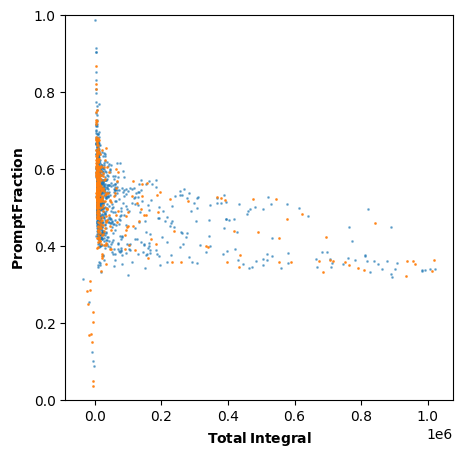

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

Int_baseline, ratio_baseline = prompt_frac(single_peak_flat_pns, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.5)
Int_baseline, ratio_baseline = prompt_frac(single_peak_flat_cos, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.8)
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.set_ylim(0, 1);

# Test Deconvolution